# Cross-validation by functional group
### *using QM optimized geometries and charges*

This notebook repeats the analysis of `functional_group_crossvalidation.ipynb`, but using descriptors calculated from optimized molecule geometries and charges via Gaussian. Parameters in `setup_model_qm` were similarly calculated to minimize the LeaveOneGroupOut CV score.

Since model performance was not substantially better than the base case using simple force-field optimized geometries, this descriptor pipeline was not pursued further due to the significant computational burden it imposes.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
from ysi_utils.models.setup_model_qm import model

from ysi_utils.data import low
from ysi_utils.descriptors import dragon_qm as dragon
from ysi_utils.validation import y_train as y
from ysi_utils.validation import y_test

X = dragon.loc[y.index]
X_test = dragon.loc[y_test.index]

Using Theano backend.


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_predict
from sklearn.metrics import median_absolute_error

*Warning*, This next step takes a lot of computational effort.

In [4]:
labels = LabelEncoder().fit_transform(low.set_index('SMILES').loc[X.index].Type)

y_cvlabel_predict = cross_val_predict(model, X.values, y.YSI.values,
                                      cv=LeaveOneLabelOut(labels))

In [5]:
y_cvlabel = pd.DataFrame(y).join(pd.Series(y_cvlabel_predict.flatten(), index=y.index, name='YSI_cv'))
y_cvlabel['YSI_diff'] = y_cvlabel.YSI_cv - y_cvlabel.YSI
medians = y_cvlabel.groupby('Type').median().YSI_diff
order = medians.index[medians.argsort()].tolist()[::-1]

median_absolute_error(y_cvlabel.YSI, y_cvlabel.YSI_cv)

6.1406846284866319

In [6]:
from ysi_utils.models import outlier_model
y_cvlabel['inlier'] = outlier_model.predict(X) == 1

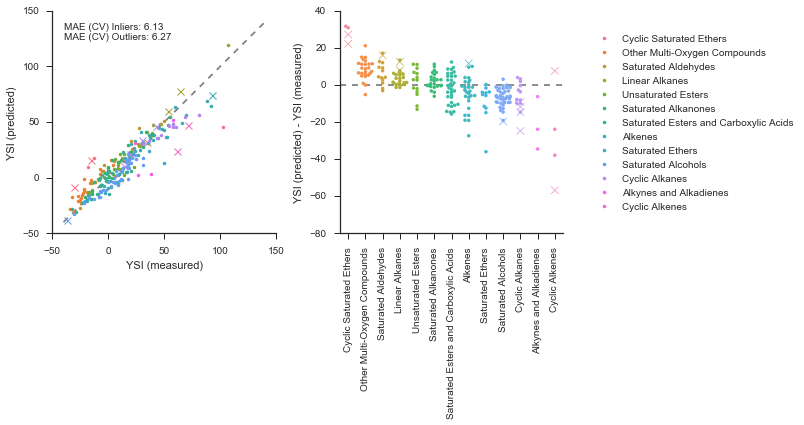

In [7]:
from swarmplot import myswarmplot

with sns.axes_style('ticks'):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(131)
    
    for moltype, color in zip(order, sns.color_palette('husl', n_colors=13)):
        df = y_cvlabel[y_cvlabel.Type == moltype]
        ax.plot(df.loc[df.inlier, 'YSI'], df.loc[df.inlier, 'YSI_cv'], '.', color=color, label=moltype)
        ax.plot(df.loc[~df.inlier, 'YSI'].values, df.loc[~df.inlier, 'YSI_cv'].values,
                'x', color=color, markeredgewidth=1.)

    
    ax.legend(loc=(2.4, .08))
    ax.set_ylabel('YSI (predicted)')
    ax.set_xlabel('YSI (measured)')
    
    ax.plot([-40, 140], [-40, 140], '--', zorder=0, color='gray')
    ax.set_xlim([-50, 150])
    ax.set_ylim([-50, 150])
    
    
    ax2 = fig.add_subplot(132)
    inlier_arrays = [y_cvlabel.loc[y_cvlabel.Type == itype, 'inlier'].values for itype in order]
    out, sp = myswarmplot(ax=ax2, x='Type', y='YSI_diff', data=y_cvlabel, order=order, size=3.5, inlier=inlier_arrays)
    #out.legend_.remove()
    
    
#    sns.swarmplot(ax=ax2, x='Type', y='YSI_diff', data=y_cvlabel, order=order)

    ax2.axhline(0, color='0.5', linestyle='--')
    ticks = plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

    ax2.set_xlabel('')
    ax2.set_ylabel(r'YSI (predicted) - YSI (measured)')
    
    fig.tight_layout()
    
    text = ('MAE (CV) Inliers: {:.2f}'.format(
        median_absolute_error(y_cvlabel.loc[y_cvlabel.inlier, 'YSI'],
                              y_cvlabel.loc[y_cvlabel.inlier, 'YSI_cv'])) + '\n' +
        'MAE (CV) Outliers: {:.2f}'.format(
        median_absolute_error(y_cvlabel.loc[~y_cvlabel.inlier, 'YSI'].values,
                              y_cvlabel.loc[~y_cvlabel.inlier, 'YSI_cv'])))
            
    ax.text(0.05, 0.95, text, transform=ax.transAxes, ha='left', va='top')
    
    sns.despine()
    #fig.savefig('figs/v3_fg/functional_group_cv.svg', transparent=True)